Here we are, now cleaning and feature engineering is done on our two original datasets, it's time to build the *full* global Dataset that will be used to train models.

How ?

Using SQL *INNER JOIN* queries to merge the three *improved* dataset built in the previous notebooks and stored in the SQL database.

> Note: The table names of the three *improved* datasets are available as constant in [my_utils](my_utils.ipynb) library:
> - TRAVEL_TABLENAME
> - WEATHER_CAT_TABLENAME
> - WEATHER_NUM_TABLENAME



In [1]:
# Load my_utils.ipynb in Notebook
from ipynb.fs.full.my_utils import *

Opening connection to database
Add pythagore() function to SQLite engine
Fraction of the dataset used to train models: 10.00%
my_utils library loaded :-)


# Merge all dataset

Before merging those datasets, display two of their fist rows to remember their content:

In [2]:
print(f"{TRAVEL_TABLENAME} dataset:")
load_sql(TRAVEL_TABLENAME, limit=2)

travel_improved dataset:
Query: SELECT * FROM travel_improved LIMIT 2 OFFSET 0


,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,weekend,day_period_afternoon,day_period_evening,day_period_morning,pickup_date,distance_in_km,km_per_hour,passenger_alone,pickup_STATION,dropoff_STATION,pickup_distance_to_STATION,dropoff_distance_to_STATION,diff_ELEVATION,diff_ASCENDING,diff_DESCENDING
0,2016-03-14 17:24:55,2016-03-14 17:32:30,-73.982155,40.767937,-73.964630,40.765602,0,0,1,0,0,2016-03-14,1.498521,11.856428,1,USW00094728,USW00094728,1.639747,1.537584,0.0,0,0
1,2016-06-12 00:43:35,2016-06-12 00:54:38,-73.980415,40.738564,-73.999481,40.731152,0,1,0,0,0,2016-06-12,1.805507,9.803659,1,USW00094728,US1NYKN0025,4.591445,5.287223,37.2,0,1


In [3]:
print(f"{WEATHER_CAT_TABLENAME} dataset:")
load_sql(WEATHER_CAT_TABLENAME, limit=2)

weather_cat_improved dataset:
Query: SELECT * FROM weather_cat_improved LIMIT 2 OFFSET 0


,DATE,WT01,WT02,WT03,WT04,WT06,WT08,WT09,WT11,WDIR_E,WDIR_N,WDIR_NE,WDIR_NW,WDIR_S,WDIR_SE,WDIR_SW,WDIR_W,PEAK_Y,SNOW_FALL,SNOW_ROAD
0,2016-01-01,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0
1,2016-01-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0


In [4]:
print(f"{WEATHER_NUM_TABLENAME} dataset:")
load_sql(WEATHER_NUM_TABLENAME, limit=2)

weather_num_improved dataset:
Query: SELECT * FROM weather_num_improved LIMIT 2 OFFSET 0


,STATION,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TSTD
0,US1CTFR0022,2016-01-01,1.3,0.0,0.0,0.0,4.833333,2.233333
1,US1CTFR0039,2016-01-01,1.3,0.0,0.0,0.0,4.833333,2.233333


## Build the JOIN SQL query

The *JOIN* query is based on three *INNER JOIN* with the main *TRAVEL_TABLENAME* dataset.

Why three joins as we have three datasets ? That should be two ? Well, the *WEATHER_NUM* dataset will be joined two times, first time to join with *pickup* informations, second time with *dropoff*.

### *TRAVEL_TABLENAME* joined to *WEATHER_CAT_TABLENAME* using *pickup_DATE* columns

*WEATHER_CAT_TABLENAME* contains informations per each day, the joing process is base on its *DATE* column and the *pickup_date* column from *TRAVEL_TABLENAME*:

    SELECT [columns selection] FROM {TRAVEL_TABLENAME} AS T
    INNER JOIN {WEATHER_CAT_TABLENAME} AS WC ON WC.DATE=T.pickup_date

### *TRAVEL_TABLENAME* and *WEATHER_NUM_TABLENAME* using *pickup_STATION* and *pickup_DATE*

*WEATHER_NUM_TABLENAME* contains a unique row for a particular day and a particular weather station (remember, I've extrapolated missing data in this [notebook](16.NYC%20Weather%20Numerical%20Dataset%20Feature%20Engineering.ipynb)). The joining process here will map *STATION* and *DATE* to *pickup_STATION* and *pickup_date* from *TRAVEL_TABLENAME*

    SELECT [columns selection] FROM {TRAVEL_TABLENAME} AS T
    INNER JOIN {WEATHER_NUM_TABLENAME} AS WNP ON (WNP.STATION=T.pickup_STATION AND WNP.DATE=T.pickup_date)


### *TRAVEL_TABLENAME* and *WEATHER_NUM_TABLENAME* using *dropoff_STATION* and *pickup_DATE*

Same logic as above, instead that we do not have values for *dropoff_date* in the *TRAVEL_TABLENAME* (choice has been made to consider only the pickup date as the date of the travel)

    SELECT [columns selection] FROM {TRAVEL_TABLENAME} AS T
    INNER JOIN {WEATHER_NUM_TABLENAME} AS WND ON (WND.STATION=T.dropoff_STATION AND WND.DATE=T.pickup_date)

### column names to be used in the *JOIN* query

Here is the schema I've used to name the columns of the resulting dataset:

- columns from *TRAVEL_TABLENAME* are taken as is (example: *pickup_datetime*)
- columns from *WEATHER_CAT_TABLENAME* are prefixed with *WC_* (example: *WC_SNOW_FALL*)
- columns from *WEATHER_NUM_TABLENAME* for *pickup JOIN* are prefixed with *WNP_* (example: *WNP_TAVG*)
- columns from *WEATHER_NUM_TABLENAME* for *dropoff JOIN* are prefixed with *WND_* (example: *WND_PRCP*)


In [5]:
# Build travel columns
columns_to_select=[f'T.{column} AS {column}' for column in load_sql(TRAVEL_TABLENAME, limit=1, verbose=False).columns]

# Append weather_cat columns
columns_to_select+=[f'WC.{column} AS WC_{column}' for column in load_sql(WEATHER_CAT_TABLENAME, limit=1, verbose=False).columns]

# Append weather_num for pickup location columns
columns_to_select+=[f'WNP.{column} AS WNP_{column}' for column in load_sql(WEATHER_NUM_TABLENAME, limit=1, verbose=False).columns]

# Append weather_num for dropoff columns
columns_to_select+=[f'WND.{column} AS WND_{column}' for column in load_sql(WEATHER_NUM_TABLENAME, limit=1, verbose=False).columns]


Build the query using the column list and *INNER JOIN* directive described above:

In [6]:
query="SELECT {} ".format(','.join(columns_to_select))
query+=f"FROM {TRAVEL_TABLENAME} AS T "
query+=f"INNER JOIN {WEATHER_CAT_TABLENAME} AS WC ON WC.DATE=T.pickup_date "
query+=f"INNER JOIN {WEATHER_NUM_TABLENAME} AS WNP ON (WNP.STATION=T.pickup_STATION AND WNP.DATE=T.pickup_date) "
query+=f"INNER JOIN {WEATHER_NUM_TABLENAME} AS WND ON (WND.STATION=T.dropoff_STATION AND WND.DATE=T.pickup_date) "


## Run the query

Nothing to say here, simply pass the above query to the *load_sql()* function to obtain a *pandas.DataFrame*

In [7]:
# Get dataset using load_sql
full_df=load_sql(query=query, verbose=False)

As expected, my three datasets are merged the way I want, and that's good news :-)


In [8]:
# Display information on the resulting dataset
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1426415 entries, 0 to 1426414
Data columns (total 58 columns):
pickup_datetime                1426415 non-null object
dropoff_datetime               1426415 non-null object
pickup_longitude               1426415 non-null float64
pickup_latitude                1426415 non-null float64
dropoff_longitude              1426415 non-null float64
dropoff_latitude               1426415 non-null float64
store_and_fwd_flag             1426415 non-null int64
weekend                        1426415 non-null int64
day_period_afternoon           1426415 non-null int64
day_period_evening             1426415 non-null int64
day_period_morning             1426415 non-null int64
pickup_date                    1426415 non-null object
distance_in_km                 1426415 non-null float64
km_per_hour                    1426415 non-null float64
passenger_alone                1426415 non-null int64
pickup_STATION                 1426415 non-null object
dropoff

## Drop useless columns for ML training

As I am building a dataset to be used to train ML models, I will drop columns that are useless for that process.

Quite easy to identify the columns to drop: It's the one that are non numeric: station name and dates.

In [9]:
# Get 'object' dtype column names
columns_to_drop=full_df.head(1).select_dtypes('object').columns

# Print result
print("Non numeric columns to drop:")
for i in columns_to_drop:
    print(" -", i)

Non numeric columns to drop:
 - pickup_datetime
 - dropoff_datetime
 - pickup_date
 - pickup_STATION
 - dropoff_STATION
 - WC_DATE
 - WNP_STATION
 - WNP_DATE
 - WND_STATION
 - WND_DATE


Use *drop()* method with the column name list build previously to drop non numeric columns

In [10]:
# Drop non numeric column from dataset
full_df.drop(columns_to_drop, axis=1, inplace=True)

Display size and some lines from the resulting dataset:

In [11]:
# print size of the dataset
nb_lines=len(full_df.index)
nb_columns=len(full_df.columns)
print("Size of the dataset: {} lines and {} columns".format(nb_lines, nb_columns))

# print first few lines
full_df.head()

Size of the dataset: 1426415 lines and 48 columns


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,weekend,day_period_afternoon,day_period_evening,day_period_morning,distance_in_km,km_per_hour,passenger_alone,pickup_distance_to_STATION,dropoff_distance_to_STATION,diff_ELEVATION,diff_ASCENDING,diff_DESCENDING,WC_WT01,WC_WT02,WC_WT03,WC_WT04,WC_WT06,WC_WT08,WC_WT09,WC_WT11,WC_WDIR_E,WC_WDIR_N,WC_WDIR_NE,WC_WDIR_NW,WC_WDIR_S,WC_WDIR_SE,WC_WDIR_SW,WC_WDIR_W,WC_PEAK_Y,WC_SNOW_FALL,WC_SNOW_ROAD,WNP_AWND,WNP_PRCP,WNP_SNOW,WNP_SNWD,WNP_TAVG,WNP_TSTD,WND_AWND,WND_PRCP,WND_SNOW,WND_SNWD,WND_TAVG,WND_TSTD
0,-73.982155,40.767937,-73.964630,40.765602,0,0,1,0,0,1.498521,11.856428,1,1.639747,1.537584,0.0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,6.3,7.4,0.0,0.0,7.50,3.100000,6.300000,7.4,0.0,0.000000,7.500000,3.100000
1,-73.980415,40.738564,-73.999481,40.731152,0,1,0,0,0,1.805507,9.803659,1,4.591445,5.287223,37.2,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,3.6,0.0,0.0,0.0,22.50,5.800000,2.233333,0.0,0.0,0.000000,22.766667,6.666667
2,-73.979027,40.763939,-74.005333,40.710087,0,0,0,0,1,6.385098,10.822201,1,1.864153,3.240232,37.2,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,1,4.9,0.0,0.0,0.0,-5.45,3.350000,0.000000,0.0,0.0,16.666667,-4.950000,3.150000
3,-74.010040,40.719971,-74.012268,40.706718,0,0,0,1,0,1.485498,12.465721,1,4.397729,3.270370,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0.0,0.0,0.0,0.0,1.70,5.333333,0.000000,0.0,0.0,0.000000,1.700000,5.333333
4,-73.973053,40.793209,-73.972923,40.782520,0,1,1,0,0,1.188588,9.836594,1,1.614272,0.500627,0.0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,1,0,0,1,0,0,2.9,0.0,0.0,0.0,8.05,4.750000,2.900000,0.0,0.0,0.000000,8.050000,4.750000


Here we are, a full 1'426'415 lines dataset of 48 features, cleaned and complete :-)

# Normalize *km_per_hour* feature

Oh, one last thing . Remember, I've used a graphical representation of the *log10()* travel speed in this [notebook](14.NYC%20Taxi%20Travel%20Dataset%20Feature%20Engineering.ipynb) to eliminate outliers. Doing so gave me a quite perfect *gauss* curve, which is far more better for ML model fitting process.

Before saving this *full* dataset, I'll transform this feature with *np.log10()* method.

Here is the actual distribution of the travel speed feature: *km_per_hour*:

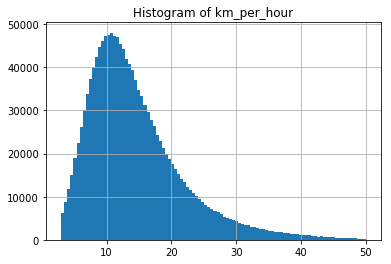

In [12]:
# Draw histogram
full_df['km_per_hour'].hist(bins=100)
plt.title('Histogram of km_per_hour')
plt.show()

Convert the feature using *np.log10()* and show the new distribution:

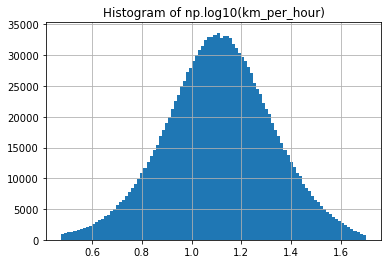

In [13]:
# Convert 'km_per_hour' with np.log10() method
full_df['km_per_hour']=np.log10(full_df['km_per_hour'])

# Draw histogram of the new values
full_df['km_per_hour'].hist(bins=100)
plt.title('Histogram of np.log10(km_per_hour)')
plt.show()

Good, it's now time to save our dataset.

Well done :-)

# Save global dataset to an NPZ file

For the rest of the project, I've decided to store datasets and various informations like *categorical* and *numerical* column names in one NPZ file.

> Note: Code taken from my [Course #4 project](https://github.com/epfl-extension-school/project-adsml19-c4-s11-3871-2111/blob/master/01%20-%20Feature%20extraction.ipynb)

## Build *categorical* and *numerical* feature names

The full dataset is made of 48 features. To identify the one wich are *numerical* and which one are *categorical* is as easy as selecting them based on their dtype:
- float => numerical
- int => categorical

> Note: The dependent variable *km_per_hour*, my Y values, is coded as *float* in the full dataset and have to be removed to build the list of *numerical* features.

In [14]:
# Get 'float' dtype column names
numerical_features=full_df.head(1).drop('km_per_hour', axis=1).select_dtypes('float').columns

# Display column name and type
full_df[numerical_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1426415 entries, 0 to 1426414
Data columns (total 20 columns):
pickup_longitude               1426415 non-null float64
pickup_latitude                1426415 non-null float64
dropoff_longitude              1426415 non-null float64
dropoff_latitude               1426415 non-null float64
distance_in_km                 1426415 non-null float64
pickup_distance_to_STATION     1426415 non-null float64
dropoff_distance_to_STATION    1426415 non-null float64
diff_ELEVATION                 1426415 non-null float64
WNP_AWND                       1426415 non-null float64
WNP_PRCP                       1426415 non-null float64
WNP_SNOW                       1426415 non-null float64
WNP_SNWD                       1426415 non-null float64
WNP_TAVG                       1426415 non-null float64
WNP_TSTD                       1426415 non-null float64
WND_AWND                       1426415 non-null float64
WND_PRCP                       1426415 non-null

In [15]:
# Get 'int' dtype column names
categorical_features=full_df.head(1).select_dtypes('int').columns

# Display column name and type
full_df[categorical_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1426415 entries, 0 to 1426414
Data columns (total 27 columns):
store_and_fwd_flag      1426415 non-null int64
weekend                 1426415 non-null int64
day_period_afternoon    1426415 non-null int64
day_period_evening      1426415 non-null int64
day_period_morning      1426415 non-null int64
passenger_alone         1426415 non-null int64
diff_ASCENDING          1426415 non-null int64
diff_DESCENDING         1426415 non-null int64
WC_WT01                 1426415 non-null int64
WC_WT02                 1426415 non-null int64
WC_WT03                 1426415 non-null int64
WC_WT04                 1426415 non-null int64
WC_WT06                 1426415 non-null int64
WC_WT08                 1426415 non-null int64
WC_WT09                 1426415 non-null int64
WC_WT11                 1426415 non-null int64
WC_WDIR_E               1426415 non-null int64
WC_WDIR_N               1426415 non-null int64
WC_WDIR_NE              1426415 non-null 

## Save to NPZ

In case I will need later in this project one of the original datasets engineered to build this *full* dataset, I will save in my NPZ file:
- The full dataset
- The categorical and numerical column names of the dataset as list of strings
- The dependent variable name as a one element list of string
- The *stations* dataset
- The *travel improved* dataset
- The *weather categorical improved* dataset
- The *weather numerical improved* dataset

Except for the *full* dataset, others will be retrieved from the SQLite database.

As I'll do later some more data exploration that might lead me to modify the *full* dataset, I've coded a function in [my_utils](my_utils.ipynb), *save_npz()*, that will take the *full* dataset as parameter and save it along with other datasets.

> Note: There is two defined constant in [my_utils](my_utils.ipynb) to designate NPZ file names: *NPZ_FILENAME* and *NPZ_NORMALIZED_FILENAME*. The first constant is the name of the file that contains not normalized data, the other constant is for the file that will contain *normalized* data. Normalization will be done in the next chapter, for the moment I save the current dataset in the *NPZ_FILENAME* file.

In [16]:
# Save datasets to an NPZ file using save_npz() function from my_utils library
save_npz(dataset=full_df, y_column='km_per_hour', y_dtype='float', npz_filename=NPZ_DATAFILE)

Numerical features:  pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,distance_in_km,pickup_distance_to_STATION,dropoff_distance_to_STATION,diff_ELEVATION,WNP_AWND,WNP_PRCP,WNP_SNOW,WNP_SNWD,WNP_TAVG,WNP_TSTD,WND_AWND,WND_PRCP,WND_SNOW,WND_SNWD,WND_TAVG,WND_TSTD
Categorical features:  store_and_fwd_flag,weekend,day_period_afternoon,day_period_evening,day_period_morning,passenger_alone,diff_ASCENDING,diff_DESCENDING,WC_WT01,WC_WT02,WC_WT03,WC_WT04,WC_WT06,WC_WT08,WC_WT09,WC_WT11,WC_WDIR_E,WC_WDIR_N,WC_WDIR_NE,WC_WDIR_NW,WC_WDIR_S,WC_WDIR_SE,WC_WDIR_SW,WC_WDIR_W,WC_PEAK_Y,WC_SNOW_FALL,WC_SNOW_ROAD
Build dict to pass to savez_compressed...
Query: SELECT * FROM stations
Query: SELECT * FROM stations LIMIT 1 OFFSET 0
Query: SELECT * FROM travel_improved
Query: SELECT * FROM travel_improved LIMIT 1 OFFSET 0
Query: SELECT * FROM weather_cat_improved
Query: SELECT * FROM weather_cat_improved LIMIT 1 OFFSET 0
Query: SELECT * FROM weather_num_improved
Query: SELECT * FROM weat

# Here we are

Our global dataset, the merge of the three engineered datasets (*travel*, *weather categorical* and *weather numerical*), is now ready to be used in EDA and Machine Learning models training.

Let's continue with the next notebook: [20.Exploratory Data Analysis](20.Exploratory%20Data%20Analysis.ipynb)